/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1: Accuracy=0.2887, Loss=1.3060, F1 Score=0.2293
Epoch 2: Accuracy=0.8286, Loss=0.6233, F1 Score=0.8339
Epoch 3: Accuracy=0.8517, Loss=0.4188, F1 Score=0.8478
Epoch 4: Accuracy=0.8586, Loss=0.4798, F1 Score=0.8560
Epoch 5: Accuracy=0.8609, Loss=0.5321, F1 Score=0.8594
Epoch 6: Accuracy=0.8600, Loss=0.5705, F1 Score=0.8569
Epoch 7: Accuracy=0.8594, Loss=0.6093, F1 Score=0.8550
Epoch 8: Accuracy=0.8569, Loss=0.6428, F1 Score=0.8534
Epoch 9: Accuracy=0.8635, Loss=0.6380, F1 Score=0.8609
Epoch 10: Accuracy=0.8631, Loss=0.6487, F1 Score=0.8594
Epoch 11: Accuracy=0.8626, Loss=0.6565, F1 Score=0.8596
Epoch 12: Accuracy=0.8631, Loss=0.6860, F1 Score=0.8607
Epoch 13: Accuracy=0.8569, Loss=0.7523, F1 Score=0.8519
Epoch 14: Accuracy=0.8624, Loss=0.6788, F1 Score=0.8598
Epoch 15: Accuracy=0.8649, Loss=0.7193, F1 Score=0.8623
Epoch 16: Accuracy=0.8649, Loss=0.7384, F1 Score=0.8617
Epoch 17: Accuracy=0.8624, Loss=0.7124, F1 Score=0.8599
Epoch 18: Accuracy=0.8623, Loss=0.7683, F1 Score=0.8583
E

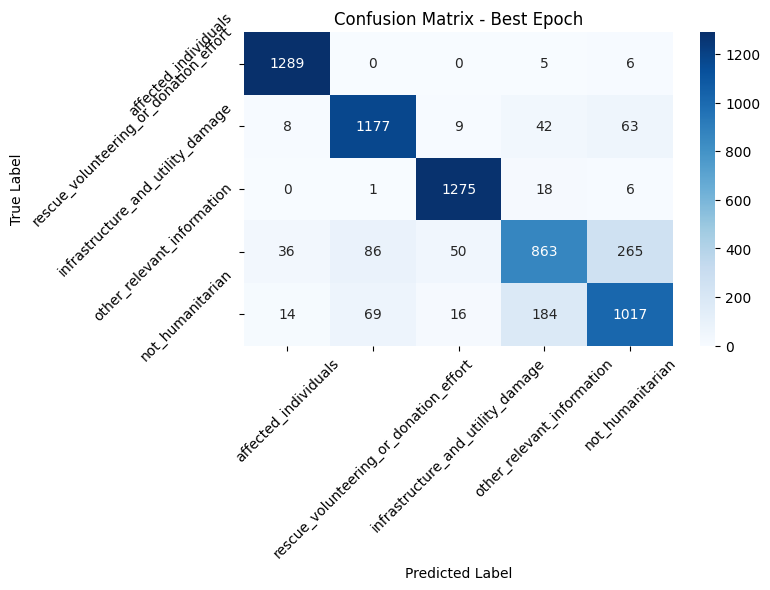

✅ Model saved to /kaggle/working/tfidf_cnn_humanitarian_best_model.h5


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip().str.lower()

# Check for required columns
if 'processed_data' not in df.columns or 'humanitarian_class' not in df.columns:
    raise ValueError("Missing 'processed_data' or 'humanitarian_class' columns.")

# Fill missing values and standardize class labels
df['processed_data'] = df['processed_data'].fillna("")
df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

# Label encoding
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}
df['label'] = df['humanitarian_class'].map(label_map)

# Handcrafted features
df['tweet_length'] = df['processed_data'].apply(len)
df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

# TF-IDF vectorization (after SMOTE)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_text = vectorizer.fit_transform(df['processed_data'])

# Handcrafted features
scaler = StandardScaler()
X_hand = scaler.fit_transform(df[['tweet_length', 'num_hashtags', 'num_mentions']])

# Combine features
X_combined = np.hstack((X_text.toarray(), X_hand))
y = df['label'].values

# Apply SMOTE to entire dataset
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_combined, y)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Build CNN-like dense model
def create_model(input_dim, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Callback to monitor F1 score per epoch
class TestMetricsLogger(Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.best_f1 = 0
        self.best_metrics = {}

    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_test, verbose=0), axis=1)
        acc = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred, average='weighted')
        loss = self.model.evaluate(self.X_test, self.y_test, verbose=0)[0]
        print(f"Epoch {epoch + 1}: Accuracy={acc:.4f}, Loss={loss:.4f}, F1 Score={f1:.4f}")
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_metrics = {
                "epoch": epoch + 1,
                "accuracy": acc,
                "loss": loss,
                "f1_score": f1,
                "y_pred": y_pred.copy()
            }

# Train model
model = create_model(X_train.shape[1], len(label_map))
logger = TestMetricsLogger(X_test, y_test)
model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=0, callbacks=[logger])

# Show best epoch result
best = logger.best_metrics
print(f"\n✅ Best Epoch: {best['epoch']} | Accuracy={best['accuracy']:.4f}, Loss={best['loss']:.4f}, F1 Score={best['f1_score']:.4f}")

# Final classification report
print("\n📋 Final Test Classification Report:\n")
print(classification_report(y_test, best['y_pred'], target_names=label_map.keys()))

# Confusion matrix
cm = confusion_matrix(y_test, best['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix - Best Epoch")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Save model
model.save("/kaggle/working/tfidf_cnn_humanitarian_best_model.h5")
print("✅ Model saved to /kaggle/working/tfidf_cnn_humanitarian_best_model.h5")
